In [1]:
import numpy as np
import pandas as pd
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression, ARDRegression, BayesianRidge, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, learning_curve, ShuffleSplit
from sklearn.impute import KNNImputer
import seaborn as sns
import matplotlib.pyplot as plt
import random

random.seed(10)

sns.set_style('whitegrid')
sns.set_context("paper", font_scale = 2)

In [2]:
file_names = ["Reserves.csv"
,"Revenue_from_coal.csv"
,"Revenue_from_forest.csv"
,"Roadways.csv"
,"Tobacco_use.csv"
,"Telephone_lines.csv"
,"Telephone_mobile.csv"
,"Total_fertility_rate.csv"
,"Unemployment_rate.csv"
,"Waterways.csv"
,"Youth_unemployment.csv"
,"Airports.csv"
,"Area.csv"
,"Birth_rate.csv"
,"Broadband_subscriptions.csv"
,"Budget_surplus_deficit.csv"
,"Carbon_emissions.csv"
,"Children_underweight.csv"
,"Current_account.csv"
,"Death_rate.csv"
,"Debt.csv"
,"Education_expenditure.csv"
,"Energy_consumption_per_capita.csv"
,"Exports.csv"
,"Gini_index_coefficient.csv"
,"Gov_revenue.csv"
,"Hiv_aids_deaths.csv"
,"Hiv_aids_num.csv"
,"Hiv_aids_rate.csv"
,"Imports.csv"
,"Industrial_growth_rate.csv"
,"Infant_mortality_rate.csv"
,"Inflation_rate.csv"
,"Internet_users.csv"
,"Labor_force.csv"
,"Life_expectancy.csv"
,"Maternal_mortality_ratio.csv"
,"Median_age.csv"
,"Merchant_marine.csv"
,"Military_expenditures.csv"
,"Net_mig_rate.csv"
,"Obesity_rate.csv"
,"Petrol_exports.csv"
,"Petrol_imports.csv"
,"Petrol_production.csv"
,"Pop_growth_rate.csv"
,"Population.csv"
,"Public_debt.csv"
,"Railways.csv"
,"Real_GDP.csv"
,"Real_GDP_growth.csv"
,"Real_GDP_per_capita.csv"]

In [3]:
HDI = pd.read_excel("HDI.xlsx", header = None)[[1, 2]]
HDI.columns = ["Name", "HDI"]
HDI

,Name,HDI
0,Norway,0.957
1,Ireland,0.955
2,Switzerland,0.955
3,Hong Kong,0.949
4,Iceland,0.949
...,...,...
184,Burundi,0.433
185,South Sudan,0.433
186,Chad,0.398
187,Central African Republic,0.397


In [4]:
df_list = []

for name in file_names:
    df = pd.read_csv(name).drop(['slug', 'date_of_information', 'ranking'], axis = 1)
    df = df.rename(columns = {'value':name.replace('.csv', ''), 'name':"Name", 'region':"Region"})
    df_list.append(df)

In [5]:
#credit: https://www.statology.org/pandas-merge-multiple-dataframes/
from functools import reduce

#merge all DataFrames into one
cia = reduce(lambda  left,right: pd.merge(left,right,on=['Name', 'Region'],
                                            how='outer'), df_list)
cia = cia.merge(HDI, on = "Name", how = 'inner')
cia.index = cia["Name"]
cia = cia.drop("Name", axis = 1)

In [6]:
cia

,Reserves,Region,Revenue_from_coal,Revenue_from_forest,Roadways,Tobacco_use,Telephone_lines,Telephone_mobile,Total_fertility_rate,Unemployment_rate,...,Petrol_imports,Petrol_production,Pop_growth_rate,Population,Public_debt,Railways,Real_GDP,Real_GDP_growth,Real_GDP_per_capita,HDI
Name,,,,,,,,,,,,,,,,,,,,,
China,"$3,236,000,000,000",East and Southeast Asia,0.57,0.08,"5,200,000",25.6,"181,908,000","1,720,000,000",1.45,3.64,...,"1,160,000","11,510,000",0.19,"1,410,539,758",47.0,"150,000.0","$23,009,780,000,000",6.14,"$16,400",0.761
Japan,"$1,264,000,000,000",East and Southeast Asia,0.00,0.02,"1,218,772",20.1,"61,978,594","195,054,893",1.38,2.36,...,"1,100,000","3,467,000",-0.39,"124,214,766",237.6,"27,311.0","$5,224,850,000,000",0.70,"$41,400",0.919
Switzerland,"$811,200,000,000",Europe,0.00,0.01,"71,557",25.5,"3,071,296","10,829,000",1.58,2.31,...,"165,100","61,550",0.65,"8,508,698",41.8,"5,466.0","$590,710,000,000",1.11,"$68,400",0.955
Saudi Arabia,"$496,400,000,000",Middle East,0.00,0.00,"221,372",14.3,"5,749,058","43,215,439",1.92,6.00,...,"609,600","2,476,000",1.63,"35,354,380",17.2,"5,410.0","$1,543,240,000,000",-0.90,"$44,300",0.854
Russia,"$432,700,000,000",Central Asia,0.53,0.29,"1,283,387",26.8,"25,892,405","238,733,217",1.60,4.60,...,"41,920","6,076,000",-0.22,"142,021,981",15.5,"87,157.0","$3,875,690,000,000",1.34,"$26,500",0.824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Solomon Islands,$0,Australia and Oceania,0.00,20.27,"1,390",36.5,"7,000","478,116",2.87,NaN,...,"1,577",0,1.72,"702,694",9.4,NaN,"$1,710,000,000",3.50,"$2,500",0.567
Antigua and Barbuda,NaN,Central America and the Caribbean,0.00,0.00,"1,170",NaN,"27,000","184,000",1.95,11.00,...,"5,065",0,1.15,"100,335",86.8,NaN,"$1,760,000,000",2.80,"$18,000",0.778
Andorra,NaN,Europe,NaN,0.00,320,31.8,"40,000","94,000",1.45,3.70,...,NaN,0,-0.10,"85,560",41.0,NaN,"$3,327,000,000",-1.10,"$49,900",0.868


In [7]:
cia.info()

<class 'pandas.core.frame.DataFrame'>
Index: 180 entries, China to Marshall Islands
Data columns (total 54 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Reserves                       176 non-null    object 
 1   Region                         180 non-null    object 
 2   Revenue_from_coal              171 non-null    float64
 3   Revenue_from_forest            177 non-null    float64
 4   Roadways                       175 non-null    object 
 5   Tobacco_use                    153 non-null    float64
 6   Telephone_lines                178 non-null    object 
 7   Telephone_mobile               180 non-null    object 
 8   Total_fertility_rate           180 non-null    float64
 9   Unemployment_rate              174 non-null    float64
 10  Waterways                      109 non-null    object 
 11  Youth_unemployment             160 non-null    float64
 12  Airports                       178 non

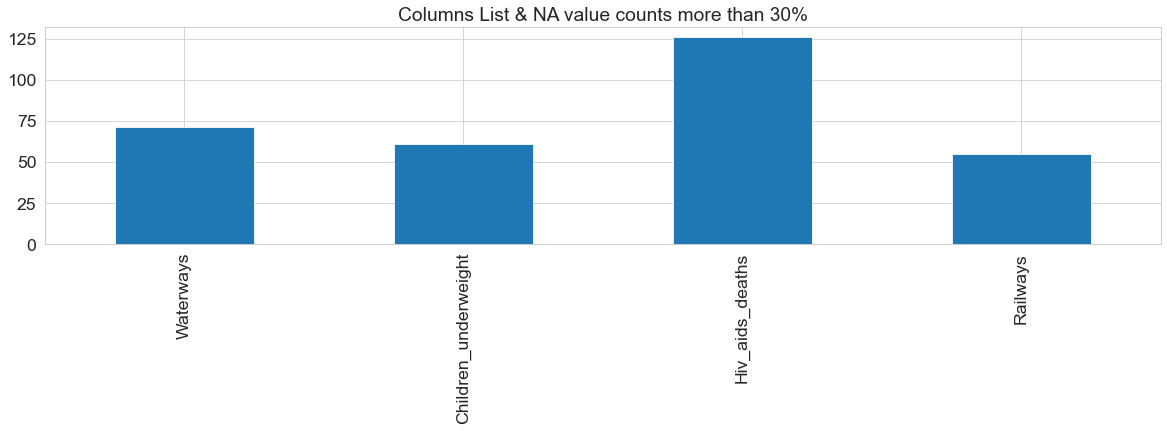

In [8]:
#credit: https://www.analyticsvidhya.com/blog/2021/06/eda-exploratory-data-analysis-with-python/#h2_3
NA_col = cia.isnull().sum()
NA_col = NA_col[NA_col.values >(0.3*len(cia))]
plt.figure(figsize=(20,4))
NA_col.plot(kind='bar')
plt.title('Columns List & NA value counts more than 30%')
plt.show()

In [9]:
cia = cia.drop(["Waterways", "Children_underweight", "Hiv_aids_deaths", "Railways"], axis = 1)

In [10]:
#columns to be converted to numeric type
cia_object_cols = cia.columns[cia.dtypes == object].drop(["Region"])
cia_object_cols

Index(['Reserves', 'Roadways', 'Telephone_lines', 'Telephone_mobile',
       'Airports', 'Area', 'Broadband_subscriptions', 'Carbon_emissions',
       'Current_account', 'Debt', 'Energy_consumption_per_capita', 'Exports',
       'Hiv_aids_num', 'Imports', 'Inflation_rate', 'Internet_users',
       'Labor_force', 'Maternal_mortality_ratio', 'Merchant_marine',
       'Petrol_exports', 'Petrol_imports', 'Petrol_production', 'Population',
       'Real_GDP', 'Real_GDP_per_capita'],
      dtype='object')

In [11]:
#preprocess numerical columns
for col in cia_object_cols:
    cia[col] = pd.to_numeric(cia[col].str.replace(",", "").str.replace("$", ""))

<ipython-input-11-17e1629dea90>:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  cia[col] = pd.to_numeric(cia[col].str.replace(",", "").str.replace("$", ""))


In [12]:
cia.info()

<class 'pandas.core.frame.DataFrame'>
Index: 180 entries, China to Marshall Islands
Data columns (total 50 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Reserves                       176 non-null    float64
 1   Region                         180 non-null    object 
 2   Revenue_from_coal              171 non-null    float64
 3   Revenue_from_forest            177 non-null    float64
 4   Roadways                       175 non-null    float64
 5   Tobacco_use                    153 non-null    float64
 6   Telephone_lines                178 non-null    float64
 7   Telephone_mobile               180 non-null    int64  
 8   Total_fertility_rate           180 non-null    float64
 9   Unemployment_rate              174 non-null    float64
 10  Youth_unemployment             160 non-null    float64
 11  Airports                       178 non-null    float64
 12  Area                           180 non

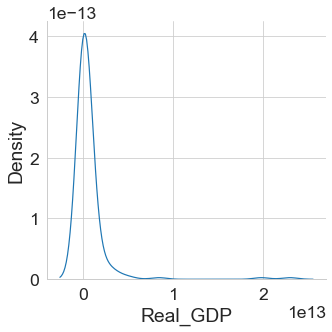

In [13]:
#EDA
sns.displot(data=cia, x = "Real_GDP", kind = "kde")

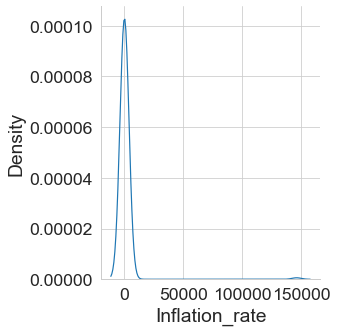

In [14]:
sns.displot(data=cia, x = "Inflation_rate", kind = "kde")

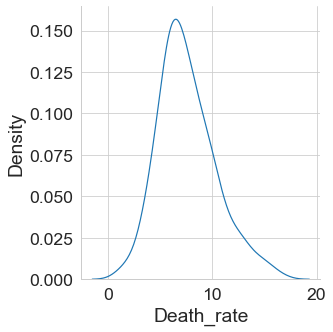

In [15]:
sns.displot(data=cia, x = "Death_rate", kind = "kde")

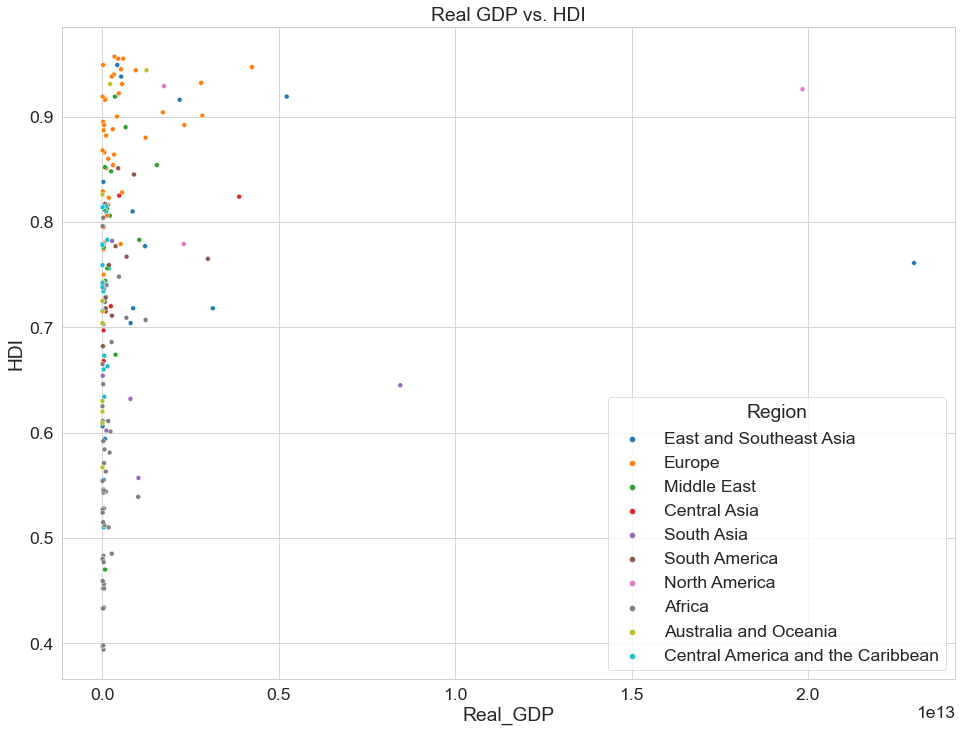

In [16]:
plt.figure(figsize=(16,12))
sns.scatterplot(data = cia, x='Real_GDP', y='HDI', hue ='Region')
plt.title('Real GDP vs. HDI')
plt.show()

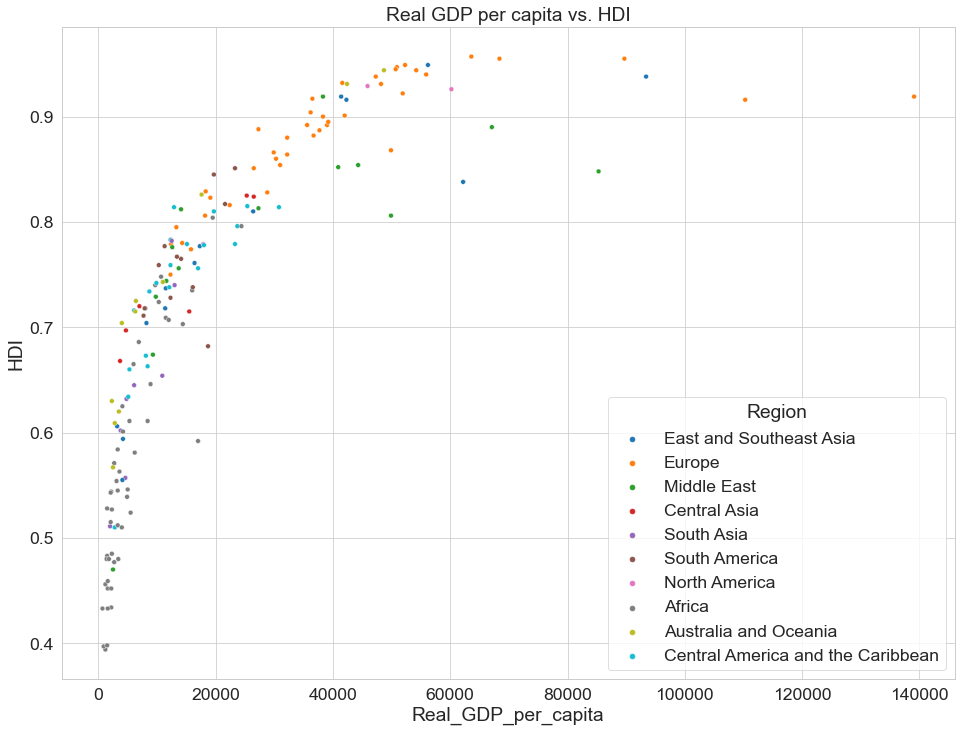

In [17]:
plt.figure(figsize=(16,12))
sns.scatterplot(data = cia, x='Real_GDP_per_capita', y='HDI', hue ='Region')
plt.title('Real GDP per capita vs. HDI')
plt.show()

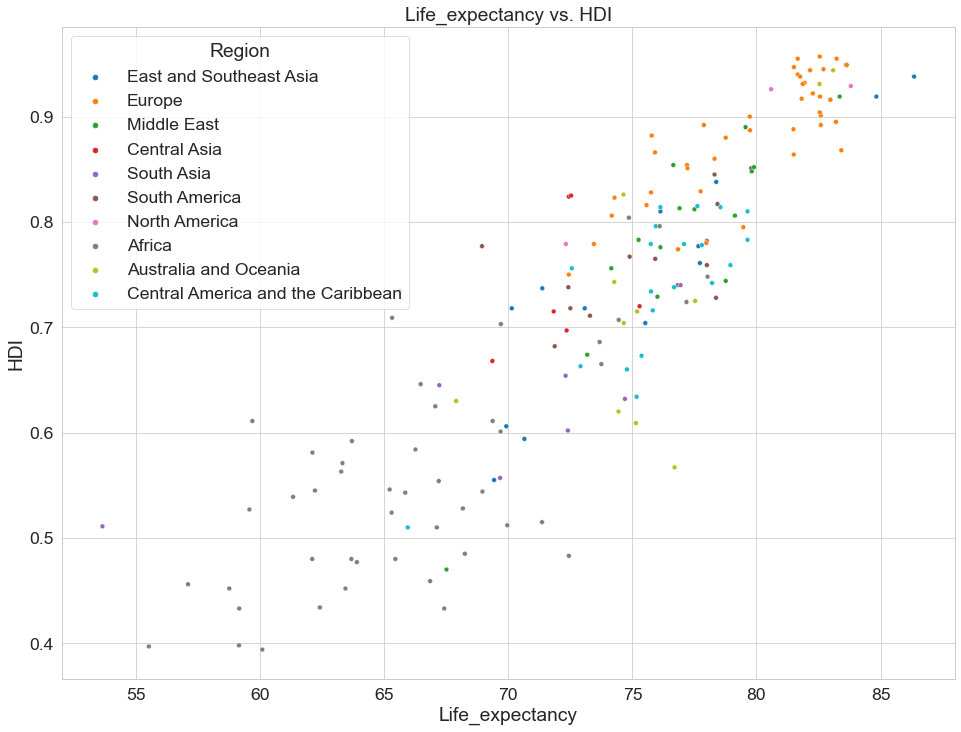

In [18]:
plt.figure(figsize=(16,12))
sns.scatterplot(data = cia, x='Life_expectancy', y='HDI', hue ='Region')
plt.title('Life_expectancy vs. HDI')
plt.show()

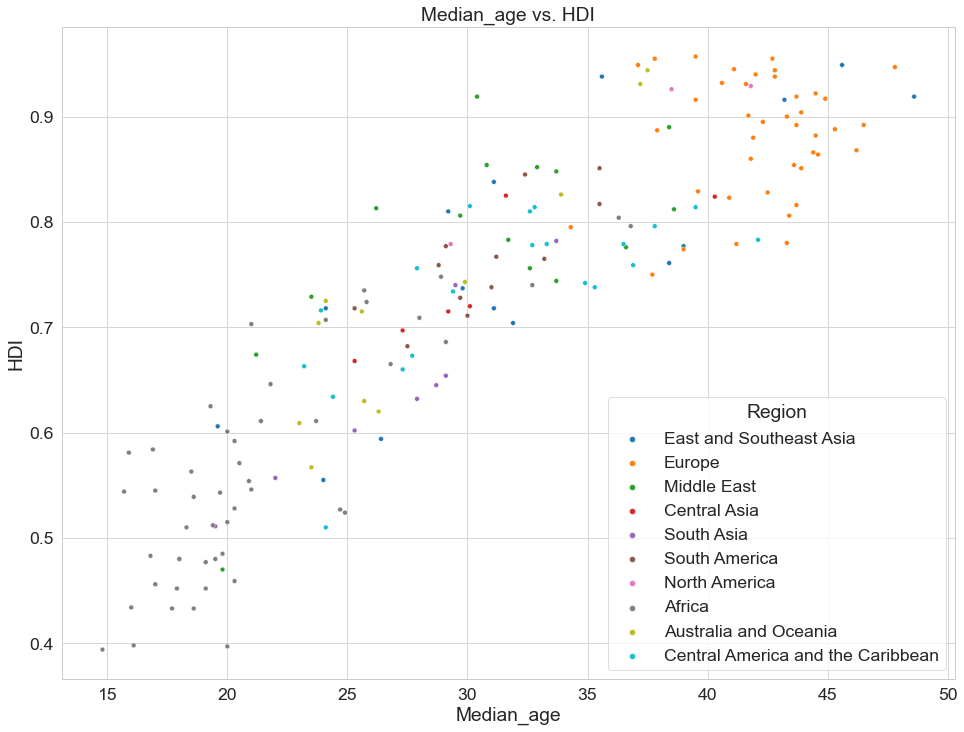

In [19]:
plt.figure(figsize=(16,12))
sns.scatterplot(data = cia, x='Median_age', y='HDI', hue ='Region')
plt.title('Median_age vs. HDI')
plt.show()

In [20]:
#encode region column
le = LabelEncoder()
cia["Region"] = le.fit_transform(cia["Region"])
cia

,Reserves,Region,Revenue_from_coal,Revenue_from_forest,Roadways,Tobacco_use,Telephone_lines,Telephone_mobile,Total_fertility_rate,Unemployment_rate,...,Petrol_exports,Petrol_imports,Petrol_production,Pop_growth_rate,Population,Public_debt,Real_GDP,Real_GDP_growth,Real_GDP_per_capita,HDI
Name,,,,,,,,,,,,,,,,,,,,,
China,3.236000e+12,4,0.57,0.08,5200000.0,25.6,181908000.0,1720000000,1.45,3.64,...,848400.0,1160000.0,11510000.0,0.19,1410539758,47.0,23009780000000,6.14,16400,0.761
Japan,1.264000e+12,4,0.00,0.02,1218772.0,20.1,61978594.0,195054893,1.38,2.36,...,370900.0,1100000.0,3467000.0,-0.39,124214766,237.6,5224850000000,0.70,41400,0.919
Switzerland,8.112000e+11,5,0.00,0.01,71557.0,25.5,3071296.0,10829000,1.58,2.31,...,7345.0,165100.0,61550.0,0.65,8508698,41.8,590710000000,1.11,68400,0.955
Saudi Arabia,4.964000e+11,6,0.00,0.00,221372.0,14.3,5749058.0,43215439,1.92,6.00,...,1784000.0,609600.0,2476000.0,1.63,35354380,17.2,1543240000000,-0.90,44300,0.854
Russia,4.327000e+11,3,0.53,0.29,1283387.0,26.8,25892405.0,238733217,1.60,4.60,...,2671000.0,41920.0,6076000.0,-0.22,142021981,15.5,3875690000000,1.34,26500,0.824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Solomon Islands,0.000000e+00,1,0.00,20.27,1390.0,36.5,7000.0,478116,2.87,NaN,...,0.0,1577.0,0.0,1.72,702694,9.4,1710000000,3.50,2500,0.567
Antigua and Barbuda,NaN,2,0.00,0.00,1170.0,NaN,27000.0,184000,1.95,11.00,...,91.0,5065.0,0.0,1.15,100335,86.8,1760000000,2.80,18000,0.778
Andorra,NaN,5,NaN,0.00,320.0,31.8,40000.0,94000,1.45,3.70,...,NaN,NaN,0.0,-0.10,85560,41.0,3327000000,-1.10,49900,0.868


Text(0.5, 1.0, 'Correlation Heatmap')

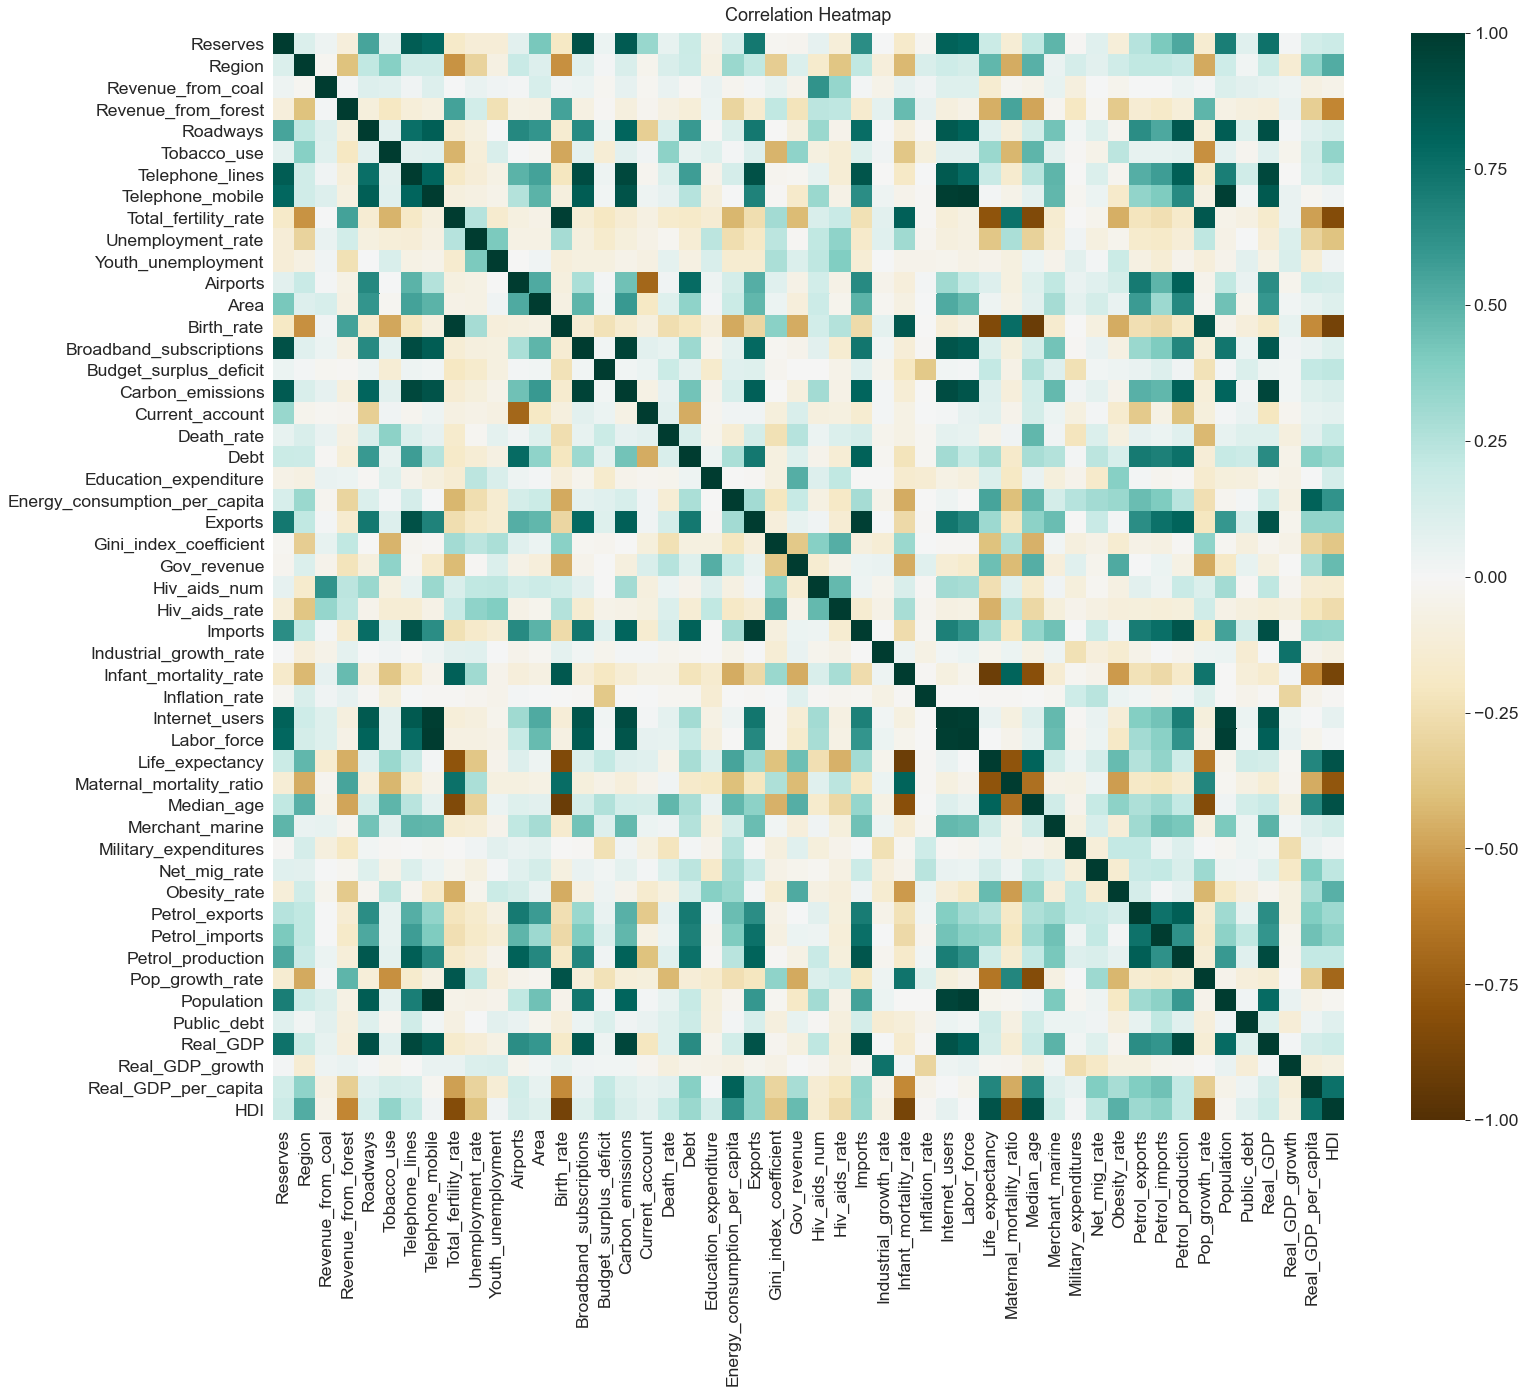

In [21]:
plt.figure(figsize=(24, 20))
heatmap = sns.heatmap(cia.corr(), vmin=-1, vmax=1, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12)

In [22]:
#Model training
X = cia.drop("HDI", axis = 1)
y = cia.HDI
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 1)
train_region = X_train["Region"]
test_region = X_test["Region"]
X

,Reserves,Region,Revenue_from_coal,Revenue_from_forest,Roadways,Tobacco_use,Telephone_lines,Telephone_mobile,Total_fertility_rate,Unemployment_rate,...,Obesity_rate,Petrol_exports,Petrol_imports,Petrol_production,Pop_growth_rate,Population,Public_debt,Real_GDP,Real_GDP_growth,Real_GDP_per_capita
Name,,,,,,,,,,,,,,,,,,,,,
China,3.236000e+12,4,0.57,0.08,5200000.0,25.6,181908000.0,1720000000,1.45,3.64,...,6.2,848400.0,1160000.0,11510000.0,0.19,1410539758,47.0,23009780000000,6.14,16400
Japan,1.264000e+12,4,0.00,0.02,1218772.0,20.1,61978594.0,195054893,1.38,2.36,...,4.3,370900.0,1100000.0,3467000.0,-0.39,124214766,237.6,5224850000000,0.70,41400
Switzerland,8.112000e+11,5,0.00,0.01,71557.0,25.5,3071296.0,10829000,1.58,2.31,...,19.5,7345.0,165100.0,61550.0,0.65,8508698,41.8,590710000000,1.11,68400
Saudi Arabia,4.964000e+11,6,0.00,0.00,221372.0,14.3,5749058.0,43215439,1.92,6.00,...,35.4,1784000.0,609600.0,2476000.0,1.63,35354380,17.2,1543240000000,-0.90,44300
Russia,4.327000e+11,3,0.53,0.29,1283387.0,26.8,25892405.0,238733217,1.60,4.60,...,23.1,2671000.0,41920.0,6076000.0,-0.22,142021981,15.5,3875690000000,1.34,26500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Solomon Islands,0.000000e+00,1,0.00,20.27,1390.0,36.5,7000.0,478116,2.87,NaN,...,22.5,0.0,1577.0,0.0,1.72,702694,9.4,1710000000,3.50,2500
Antigua and Barbuda,NaN,2,0.00,0.00,1170.0,NaN,27000.0,184000,1.95,11.00,...,18.9,91.0,5065.0,0.0,1.15,100335,86.8,1760000000,2.80,18000
Andorra,NaN,5,NaN,0.00,320.0,31.8,40000.0,94000,1.45,3.70,...,25.6,NaN,NaN,0.0,-0.10,85560,41.0,3327000000,-1.10,49900


In [23]:
X_cols = X.columns.drop("Region")
X_train_idx = X_train.index
X_test_idx = X_test.index
scaler = RobustScaler().fit(X_train.drop("Region", axis = 1))
imputer = KNNImputer().fit(X_train.drop("Region", axis = 1))
X_train = pd.DataFrame(scaler.transform(imputer.transform(X_train.drop("Region", axis = 1))))
X_test = pd.DataFrame(scaler.transform(imputer.transform(X_test.drop("Region", axis = 1))))
X_train.index = X_train_idx
X_test.index = X_test_idx
X_train.columns = X_cols
X_test.columns = X_cols
X_train["Region"] = train_region
X_test["Region"] = test_region
X_train

C:\Users\Justin\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
C:\Users\Justin\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


,Reserves,Revenue_from_coal,Revenue_from_forest,Roadways,Tobacco_use,Telephone_lines,Telephone_mobile,Total_fertility_rate,Unemployment_rate,Youth_unemployment,...,Petrol_exports,Petrol_imports,Petrol_production,Pop_growth_rate,Population,Public_debt,Real_GDP,Real_GDP_growth,Real_GDP_per_capita,Region
Name,,,,,,,,,,,,,,,,,,,,,
Belize,-0.166544,0.0,0.101562,-0.310577,-0.863469,-0.170220,-0.349631,0.471311,0.308814,0.197183,...,-0.063894,-0.275379,-0.060616,0.568,-0.316668,1.454819,-0.219711,-0.517110,-0.284689,2
Kazakhstan,0.759025,99.0,-0.140625,0.718286,0.221402,1.115154,0.710637,0.053279,-0.223843,-0.773083,...,1.836510,0.069810,1.285986,-0.128,0.370303,-0.900602,1.270298,1.104183,0.633971,3
Azerbaijan,0.027124,0.0,-0.125000,-0.070215,0.280443,0.513342,0.095141,-0.151639,-0.198478,-0.234742,...,0.770202,-0.261407,0.582719,-0.208,0.043025,0.102410,0.209184,-0.730038,0.078947,6
Madagascar,-0.127381,0.0,3.250000,0.003545,0.560886,-0.149299,0.338907,1.290984,-0.604312,-0.798122,...,-0.063894,-0.130042,-0.060783,1.072,0.687778,-0.442771,-0.095562,0.517110,-0.504785,0
Liechtenstein,-0.161064,0.0,-0.140625,-0.339941,0.408856,-0.172895,-0.359122,-0.290984,-0.528218,0.287324,...,-0.063894,-0.255773,-0.060783,-0.168,-0.330152,-0.283133,-0.211681,-0.212928,6.078947,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Lesotho,-0.156035,0.0,2.468750,-0.281125,0.302583,-0.173327,-0.292331,0.717213,2.731135,1.211268,...,-0.063894,-0.265929,-0.060783,-0.136,-0.252204,-0.512048,-0.211989,-1.247148,-0.466507,0
Eswatini,-0.158911,10.0,1.617187,-0.305172,-0.811808,-0.161851,-0.306434,0.323770,2.718453,1.937402,...,-0.063894,-0.264340,-0.060783,-0.144,-0.291000,-0.671687,-0.196672,-0.273764,-0.174641,0
Nepal,0.100409,0.0,0.210938,-0.036885,0.752768,0.125600,1.324788,-0.118852,-0.452124,0.328638,...,-0.063894,-0.058553,-0.060783,-0.120,0.778024,-0.731928,0.121596,1.642586,-0.394737,9


In [24]:
baseline = LinearRegression()
baseline.fit(X_train, y_train)
baseline_y_test_pred = baseline.predict(X_test)
baseline_y_train_pred = baseline.predict(X_train)
baseline_train_error = mean_absolute_error(y_train, baseline_y_train_pred)
baseline_test_error = mean_absolute_error(y_test, baseline_y_test_pred)
baseline_train_error, baseline_test_error

(0.02311601035131146, 0.04100105098792252)

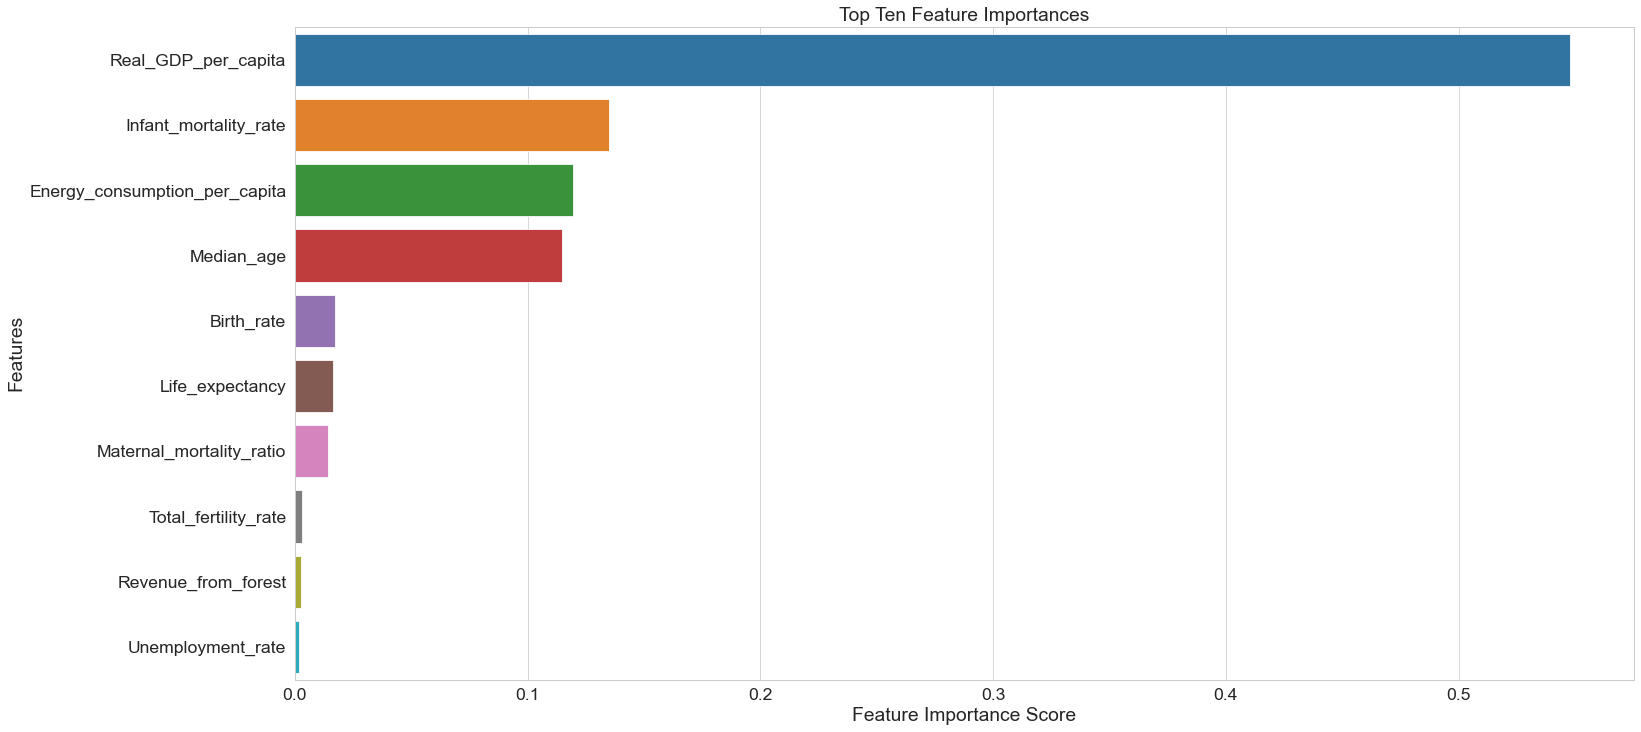

In [25]:
plt.figure(figsize=(24, 12))
#fitting RF for feature importance
rf1 = RandomForestRegressor(n_estimators=100, random_state = 1)
cols = X.columns
X=pd.DataFrame(KNNImputer().fit_transform(X))
X.columns = cols
rf1.fit(X, y)
feature_imp = pd.Series(rf1.feature_importances_,index=X.columns).sort_values(ascending=False)
# Creating a bar plot
sns.barplot(x=feature_imp[0:10], y=feature_imp.index[0:10])
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Top Ten Feature Importances")
plt.show()

In [26]:
#feature_selection
features = X.columns
features_GDP_per_capita = X.columns.drop(["Energy_consumption_per_capita", "Pop_growth_rate", "Exports", "Carbon_emissions",
                                         "Labor_force", "Internet_users", "Real_GDP", "Telephone_mobile", "Birth_rate",
                                         "Petrol_production", "Broadband_subscriptions", "Roadways", "Median_age", 
                                         "Telephone_lines", "Imports", "Life_expectancy", "Reserves"])
features_Energy_consumption_per_capita = X.columns.drop(["Real_GDP_per_capita", "Pop_growth_rate", "Labor_force", "Imports", "Internet_users",
                                                        "Carbon_emissions", "Telephone_mobile", "Real_GDP", "Birth_rate", "Petrol_production",
                                                        "Population", "Telephone_lines", "Median_age", "Exports", "Reserves", "Life_expectancy"])
features_Median_age = X.columns.drop(["Birth_rate", "Pop_growth_rate", "Infant_mortality_rate", "Imports", "Labor_force",
                                     "Carbon_emissions", "Telephone_mobile", "Internet_users", "Real_GDP", "Petrol_production",
                                     "Population", "Median_age", "Telephone_lines", "Exports", "Reserves", "Life_expectancy"])
features_Infant_mortality_rate = X.columns.drop(["Pop_growth_rate", "Maternal_mortality_ratio", "Life_expectancy", 
                                                 "Birth_rate", "Total_fertility_rate", "Labor_force", "Imports",
                                                "Carbon_emissions", "Telephone_mobile", "Internet_users", "Real_GDP",
                                                "Petrol_production", "Population", "Broadband_subscriptions", "Exports",
                                                "Reserves", "Median_age"])
y_vif, X_vif = dmatrices('HDI ~' + "+".join(features_Infant_mortality_rate), X_train.assign(HDI = y_train), return_type='dataframe')

In [27]:
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
vif["features"] = X_vif.columns
vif.round(1)

,VIF,features
0,6.0,Intercept
1,2.1,Region
2,1.3,Revenue_from_coal
3,1.7,Revenue_from_forest
4,3.4,Roadways
5,2.1,Tobacco_use
6,5.7,Telephone_lines
7,1.5,Unemployment_rate
8,2.0,Youth_unemployment
9,3.1,Airports


In [28]:
sm.add_constant(X_vif)
linreg = sm.OLS(y_vif, X_vif).fit()
print(linreg.summary())

                            OLS Regression Results                            
Dep. Variable:                    HDI   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     44.52
Date:                Sat, 13 Aug 2022   Prob (F-statistic):           1.29e-49
Time:                        02:24:40   Log-Likelihood:                 261.40
No. Observations:                 144   AIC:                            -456.8
Df Residuals:                     111   BIC:                            -358.8
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

In [42]:
#find best feature set
feature_sets = {"all":features, "GDP per capita":features_GDP_per_capita,
               "Energy consumption per capita":features_Energy_consumption_per_capita, "Median_age":features_Median_age, 
               "Infant mortality rate":features_Infant_mortality_rate}
for key in feature_sets:
    linreg = LinearRegression()
    linreg.fit(X_train[feature_sets[key]], y_train)
    cv_score = cross_val_score(linreg, X_train[feature_sets[key]], y_train, cv = 5, scoring = "neg_mean_squared_error") * -1
    print("Mean squared error scores computed {}: {}".format(key, np.mean(cv_score)))

Mean squared error scores computed all: 0.18933437072127593
Mean squared error scores computed GDP per capita: 3.9463347400458533
Mean squared error scores computed Energy consumption per capita: 20.665516766732456
Mean squared error scores computed Median_age: 0.1883113411130098
Mean squared error scores computed Infant mortality rate: 33.93628749133756


In [43]:
#credit:https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
#hyperparameter tuning
model_names = ["ARD", "Decision Tree", "Random Forest", "Ridge"]
model_list = [ARDRegression(), DecisionTreeRegressor(), RandomForestRegressor(), Ridge()]
model_dict = dict(zip(model_names, model_list))
param_grid_list = [{"alpha_1":np.logspace(-13.3, -13.1, 200), 
                  "alpha_2":np.logspace(-2.5, -2.2, 200), 
                  "lambda_1":np.logspace(-13.3, -13.1, 200),
                  "lambda_2":np.logspace(-5.4, -5.2, 200)},
                   {"splitter":["best","random"],
                    "max_depth" : [1,3,5,7,9,11,12],
                    "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
                    "min_weight_fraction_leaf":[0.1,0.2,0.3,0.4,0.5],
                    "max_features":["auto","log2","sqrt",None],
                    "max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90] },
                   {"n_estimators":[int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
                   "max_features":['auto', 'sqrt'],
                   "max_depth":[int(x) for x in np.linspace(10, 110, num = 11)],
                   "min_samples_split":[2, 5, 10],
                   "min_samples_leaf":[1, 2, 4],
                   "bootstrap":[True, False]},
                   {"alpha":np.logspace(-1, 1, 1000)}]
param_grid_dict = dict(zip(model_names, param_grid_list))


In [44]:
for key in model_dict:
    model = model_dict[key]
    param_grid = param_grid_dict[key]
    model_cv = RandomizedSearchCV(model, param_distributions = param_grid, scoring = 'neg_mean_absolute_error',
                                  n_jobs = 4, random_state = 1, cv = 5, verbose = 1)
    model_cv.fit(X_train[feature_sets['Median_age']], y_train)
    cv_score = cross_val_score(model_cv, X_train[feature_sets["Median_age"]], y_train, cv = 5, scoring = "neg_mean_absolute_error") * -1
    print("Mean absolute error scores computed {}: {}".format(key, np.mean(cv_score)))
    print(model_cv.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Mean absolute error scores computed ARD: 0.03948133449918975
{'lambda_2': 4.287072262692468e-06, 'lambda_1': 7.462155959982303e-14, 'alpha_2': 0.00530423938067649, 'alpha_1': 6.708619586547211e-14}
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Mean absolute error scores computed Decision Tree: 0.05255497027964501

In [45]:
rf = RandomForestRegressor()
param_grid = {"n_estimators":[1200],
              "max_features":['auto'],
              "max_depth":[50],
              "min_samples_split":[2],
              "min_samples_leaf":[2],
              "bootstrap":[True]}
rf_cv = GridSearchCV(rf, param_grid = param_grid, scoring = 'neg_mean_absolute_error', 
                            n_jobs = 4, cv = 5, verbose = 1)
rf_cv.fit(X_train[feature_sets['Median_age']], y_train)
rf_cv_score = cross_val_score(rf_cv, X_train[feature_sets["Median_age"]], y_train, cv = 5, scoring = "neg_mean_absolute_error") * -1

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [46]:
print("Random Forest Regressor:")
print("Mean absolute error train scores computed: {}".format(mean_absolute_error(y_train, rf_cv.predict(X_train[feature_sets['Median_age']]))))
print("Mean absolute error cross val scores computed: {}".format(np.mean(rf_cv_score)))
print("Mean absolute error test scores computed: {}".format(mean_absolute_error(y_test, rf_cv.predict(X_test[feature_sets['Median_age']]))))
print("Best Parameters: " + str(rf_cv.best_params_))

Random Forest Regressor:
Mean absolute error train scores computed: 0.012251582389495336
Mean absolute error cross val scores computed: 0.03172102782519655
Mean absolute error test scores computed: 0.026743280394888165
Best Parameters: {'bootstrap': True, 'max_depth': 50, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 1200}


In [47]:
dt = DecisionTreeRegressor()
param_grid = {"splitter":["best"],
              "max_depth" : [5],
              "min_samples_leaf":[1, 2, 3, 4, 5, 6],
              "min_weight_fraction_leaf":[0.1],
              "max_features":["auto"],
              "max_leaf_nodes":[None] }
dt_cv = GridSearchCV(dt, param_grid = param_grid, scoring = 'neg_mean_absolute_error', 
                            n_jobs = -1, cv = 5, verbose = 1)
dt_cv.fit(X_train[feature_sets['Median_age']], y_train)
dt_cv_score = cross_val_score(dt_cv, X_train[feature_sets["Median_age"]], y_train, cv = 5, scoring = "neg_mean_absolute_error") * -1

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits


In [48]:
print("Decision Tree Regressor:")
print("Mean absolute error train scores computed: {}".format(mean_absolute_error(y_train, dt_cv.predict(X_train[feature_sets['Median_age']]))))
print("Mean absolute error cross val scores computed: {}".format(np.mean(dt_cv_score)))
print("Mean absolute error test scores computed: {}".format(mean_absolute_error(y_test, dt_cv.predict(X_test[feature_sets['Median_age']]))))
print("Best Parameters: " + str(dt_cv.best_params_))

Decision Tree Regressor:
Mean absolute error train scores computed: 0.03011263389615105
Mean absolute error cross val scores computed: 0.043637561373427766
Mean absolute error test scores computed: 0.0355538247397724
Best Parameters: {'max_depth': 5, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.1, 'splitter': 'best'}


In [49]:
ard = ARDRegression()
param_grid = {"alpha_1":[6.309573444801943e-14],#np.logspace(-13.2, -13, 1000), 
              "alpha_2":[0.003595662282428345],#np.logspace(-2.6, -2.3, 7), 
              "lambda_1":[5.0118723362727144e-14],#np.logspace(-13.3, -13.2, 25),
              "lambda_2":[6.080224261649415e-06]}#np.logspace(-5.3, -5.1, 10)}
ard_cv = GridSearchCV(ard, param_grid = param_grid, scoring = 'neg_mean_absolute_error', 
                            n_jobs = -1, cv = 5, verbose = 1)
ard_cv.fit(X_train[feature_sets['Median_age']], y_train)
ard_cv_score = cross_val_score(ard_cv, X_train[feature_sets["Median_age"]], y_train, cv = 5, scoring = "neg_mean_absolute_error") * -1

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [50]:
print("ARD Regression:")
print("Mean absolute error train scores computed: {}".format(mean_absolute_error(y_train, ard_cv.predict(X_train[feature_sets['Median_age']]))))
print("Mean absolute error cross val scores computed: {}".format(np.mean(ard_cv_score)))
print("Mean absolute error test scores computed: {}".format(mean_absolute_error(y_test, ard_cv.predict(X_test[feature_sets['Median_age']]))))
print("Best Parameters: " + str(ard_cv.best_params_))

ARD Regression:
Mean absolute error train scores computed: 0.03602228411326464
Mean absolute error cross val scores computed: 0.03949471019497434
Mean absolute error test scores computed: 0.042831898307018196
Best Parameters: {'alpha_1': 6.309573444801943e-14, 'alpha_2': 0.003595662282428345, 'lambda_1': 5.0118723362727144e-14, 'lambda_2': 6.080224261649415e-06}


In [51]:
r = Ridge()
param_grid = {"alpha":np.logspace(-1, .5, 1000)}
r_cv = GridSearchCV(r, param_grid = param_grid, scoring = 'neg_mean_absolute_error', n_jobs = -1, cv = 5, verbose = 2)
r_cv.fit(X_train[feature_sets['Median_age']], y_train)
r_cv_score = cross_val_score(r_cv, X_train[feature_sets["Median_age"]], y_train, cv = 5, scoring = "neg_mean_absolute_error") * -1

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


In [52]:
print("Ridge Regression:")
print("Mean absolute error train scores computed: {}".format(mean_absolute_error(y_train, r_cv.predict(X_train[feature_sets['Median_age']]))))
print("Mean absolute error cross val scores computed: {}".format(np.mean(r_cv_score)))
print("Mean absolute error test scores computed: {}".format(mean_absolute_error(y_test, r_cv.predict(X_test[feature_sets['Median_age']]))))
print("Best Parameters: " + str(r_cv.best_params_))

Ridge Regression:
Mean absolute error train scores computed: 0.03158459988730351
Mean absolute error cross val scores computed: 0.08594989774585268
Mean absolute error test scores computed: 0.05974919116866114
Best Parameters: {'alpha': 3.1622776601683795}


In [53]:
model_cv_list = [ard_cv, dt_cv, rf_cv, r_cv]
model_cv_dict = dict(zip(model_names, model_cv_list))

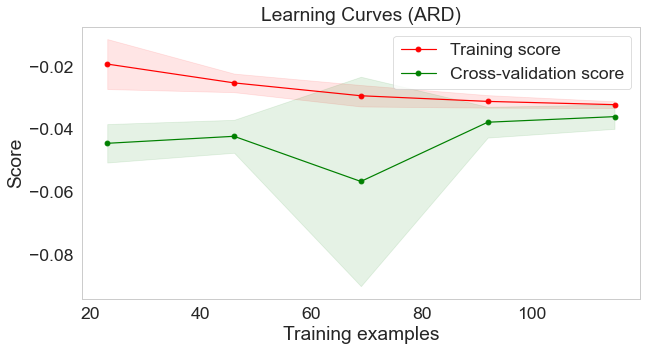

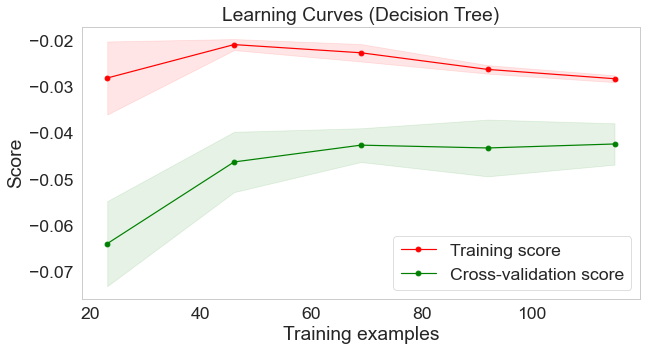

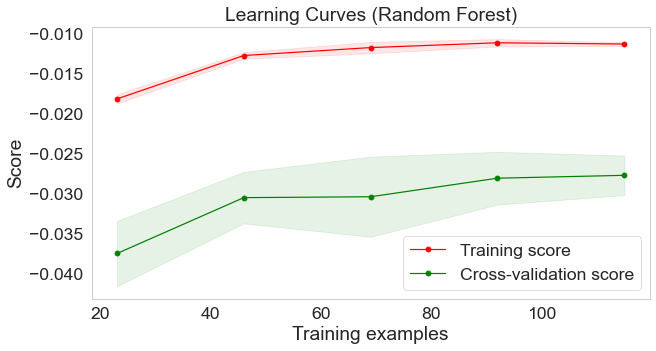

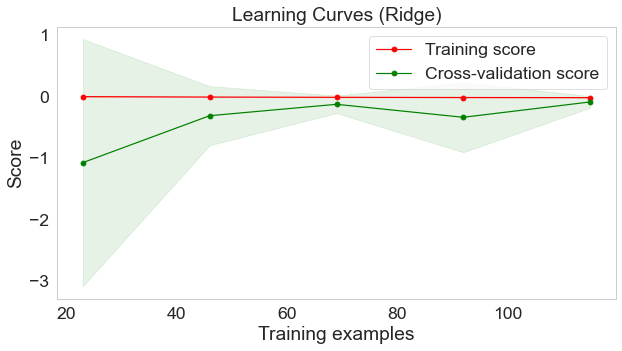

In [54]:
for key in model_cv_dict:    
    fig, axes = plt.subplots(1, 1, figsize=(10, 5))

    axes.set_title("Learning Curves ({})".format(key))

    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")
    
    train_sizes, train_scores, test_scores, _, _ = learning_curve(
        model_cv_dict[key],
        X_train,
        y_train,
        scoring='neg_mean_absolute_error',
        cv=5,
        n_jobs=4,
        train_sizes=np.linspace(.2, 1, 5),
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1) 
    train_scores_std = np.std(train_scores, axis=1) 
    test_scores_mean = np.mean(test_scores, axis=1) 
    test_scores_std = np.std(test_scores, axis=1) 

    # Plot learning curve
    axes.grid()
    axes.fill_between(
    train_sizes,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.1,
    color="r",
    )
    axes.fill_between(
    train_sizes,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.1,
    color="g",
    )
    axes.plot(
    train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes.plot(
    train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes.legend(loc="best")